In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Code mixed from https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f and https://www.tensorflow.org/text/tutorials/classify_text_with_bert#define_your_model

# Install Dependencies

In [ ]:
!pip install transformers

from transformers import BertTokenizer
import torch
from torch import nn
from transformers import BertModel

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(100)

In [ ]:
# Turn texts to strings of tokens
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')

# Build A Dataset: OxML Data and Environmental Data

We can play around with encoding the whole text or just paragraphs at a time (aggregating/maxxing out over the per-paragraph predictions). The code for getting the env_lis_2 data is in the Sweep version of this notebook.

In [ ]:
# Get OxML texts
my_file = open('/content/drive/MyDrive/oxml2023mlcases-esg-classifier/oxml_esg_texts.txt', "r")
data = my_file.read()
texts = data.split("unique_linebreak \n")
my_file.close()

# Get ESG labels
df = pd.read_csv('/content/drive/MyDrive/oxml2023mlcases-esg-classifier/data/labels.csv')

labels = {
    'governance': 0,
    'social': 1,
    'environmental': 2,
    'other': 3
}

# Add text column to label dataframe
df['text'] = texts[:-1]

''' -------------------------------------------------------------------- '''



''' -------------------------------------------------------------------- '''

# Get extra environmental texts
my_file = open('/content/drive/MyDrive/oxml2023mlcases-esg-classifier/data/HF_Chatbot_Environmental_6.15.23.txt', "r")
data = my_file.read()
env_texts = data.split("\n")
my_file.close()

# Create environmental labels for extra texts
env_labels = ['environmental'] * len(env_texts)

# Add extra environmental texts to working dataframe
for i, j in zip(env_texts, env_labels):
    df = df.append({'text': i, 'class': j}, ignore_index=True)

''' -------------------------------------------------------------------- '''

# Get extra social texts
my_file = open('/content/drive/MyDrive/oxml2023mlcases-esg-classifier/data/HF_Chatbot_Social_6.14.23.txt', "r")
data = my_file.read()
social_texts = data.split("\n")
my_file.close()

# Create social labels for extra texts
social_labels = ['social'] * len(social_texts)

# Add extra social texts to working dataframe
for i, j in zip(social_texts, social_labels):
    df = df.append({'text': i, 'class': j}, ignore_index=True)

''' -------------------------------------------------------------------- '''

# Get extra other texts
my_file = open('/content/drive/MyDrive/oxml2023mlcases-esg-classifier/data/HF_Chatbot_Other.txt', "r")
data = my_file.read()
other_texts = data.split("\n")
my_file.close()

# Create social labels for extra texts
other_labels = ['other'] * len(other_texts)

# Add extra social texts to working dataframe
for i, j in zip(other_texts, other_labels):
    df = df.append({'text': i, 'class': j}, ignore_index=True)

''' -------------------------------------------------------------------- '''

# Get extra governance texts
my_file = open('/content/drive/MyDrive/oxml2023mlcases-esg-classifier/data/HF_Chatbot_Governance.txt', "r")
data = my_file.read()
gov_texts = data.split("\n")
my_file.close()

# Create social labels for extra texts
gov_labels = ['governance'] * len(gov_texts)

# Add extra social texts to working dataframe
for i, j in zip(gov_texts, gov_labels):
    df = df.append({'text': i, 'class': j}, ignore_index=True)

In [ ]:
print("The dataframe has {} columns".format(len(df)))

In [ ]:
# could change max length back to 512

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[l] for l in df['class']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 64, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y # -> a batch of tokenized texts and the corresponding labels

In [ ]:
#Split the data into train and test
df_train, df_val = train_test_split(df, test_size=0.2, shuffle=True)

print(len(df_train), len(df_val))

3771 943


# Build A BERT Classification Model
This is just layering a linear classifier on top of BERT, so we can grab its embedded class token and pass that through the classifier.

In [ ]:
# Original classifier idea
class BertClassifier(nn.Module):
  def __init__(self, dropout=0.5):

    super(BertClassifier, self).__init__()

    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, 4) # -> input is a pooled 768-dim class embedding vector from transformer, and output is 4 classes
    self.relu = nn.ReLU()

  def forward(self, input_id, mask):
    # _ contains embedding vectors for all tokens in a sequence, and out contains the embedding vector of the class token for that sequence
    _, out = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)

    # the embedding vector for the class token gets passed through these layers for classification
    out = self.dropout(out)
    out = self.linear(out)
    out = self.relu(out)

    return out

# Train the Classification Model

In [ ]:
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import f1_score

In [ ]:
def get_f1(labels, preds):
  avg = []

  for i, j in zip(labels, preds):
    f1 = f1_score(i, j, labels=np.unique(j), average='macro')
    avg.append(f1)

  total_f1 = sum(avg)/len(avg)

  return total_f1

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

  # set up datasets
  train, val = Dataset(train_data), Dataset(val_data)

  # load the datasets
  train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

  # try for a GPU
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  # define loss and optimizer
  loss = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=learning_rate)

  avg_train_f1 = []
  avg_val_f1 = []

  if use_cuda:
    model = model.cuda()
    loss = loss.cuda()

  for epoch in range(epochs):

    train_outputs = []
    train_labels = []
    val_outputs = []
    val_labels = []

    train_acc = 0
    train_loss = 0

    for train_input, train_label in tqdm(train_dataloader):

      # pass this stuff to the GPU
      train_label = train_label.to(device)
      train_labels.append(train_label.cpu().numpy())
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)

      # feed data to model
      output = model(input_id, mask)
      train_outputs.append(output.argmax(dim=1).cpu().numpy())

      # calculate loss
      batch_loss = loss(output, train_label.long())
      train_loss += batch_loss.item()

      # calculate accuracy -> likeliest label correct?
      acc = (output.argmax(dim=1) == train_label).sum().item()
      train_acc += acc

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()

    val_acc = 0
    val_loss = 0

    # proper backprop for validation mode
    with torch.no_grad():

      for val_input, val_label in val_dataloader:

        val_label = val_label.to(device)
        val_labels.append(val_label.cpu().numpy())
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)
        val_outputs.append(output.argmax(dim=1).cpu().numpy())

        batch_loss = loss(output, val_label.long())
        val_loss += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()
        val_acc += acc

    avg_train_f1.append(get_f1(train_labels, train_outputs))
    avg_val_f1.append(get_f1(val_labels, val_outputs))

  print(
  f'Epochs: {epoch + 1} | Train Loss: {train_loss / len(train_data): .3f} \
  | Train Accuracy: {train_acc / len(train_data): .3f} \
  | Train F1: {avg_train_f1[-1]: .3f} \
  | Val Loss: {val_loss / len(val_data): .3f} \
  | Val Accuracy: {val_acc / len(val_data): .3f} \
  | Val F1: {avg_val_f1[-1]: .3f}')

In [ ]:
model = BertClassifier()

epochs = 10
batch_size = 4
learning_rate = 1e-5

train(model, df_train, df_val, learning_rate, epochs)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 943/943 [00:36<00:00, 25.82it/s]


Epochs: 10 | Train Loss:  0.007   | Train Accuracy:  0.989   | Train F1:  0.987   | Val Loss:  0.079   | Val Accuracy:  0.937   | Val F1:  0.928


In [ ]:
#Save a model
#PATH = '/content/drive/MyDrive/oxml2023mlcases-esg-classifier/esg_transformer_61523.pth'
#torch.save(model, PATH)

#Save a model's parameters
#PATH = '/content/drive/MyDrive/oxml2023mlcases-esg-classifier/esg_transformer_61523_params.pth'
#torch.save(model.state_dict(), PATH)

# Inference

In [ ]:
!pip install PyMuPDF

from pathlib import Path
import re
import fitz
import pandas as pd
from PIL import Image

import torch

device = torch.device("cuda"if torch.cuda.is_available() else"cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 90.9 MB/s eta 0:00:00


In [ ]:
# directories & files
DIR_DATA = Path("/content/drive/MyDrive/oxml2023mlcases-esg-classifier/data/")
REPORTS_DIR = "reports/"
LABELS_FILE = "labels.csv"

# columns
C_ID, C_CLASS = "id", "class"

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/oxml2023mlcases-esg-classifier/sample_submission.csv")

In [ ]:
def create_filepath(filename):
    return DIR_DATA / REPORTS_DIR / filename

def read_page(filename, page_number):
    filepath = create_filepath(filename)
    doc = fitz.open(filepath)
    page_index = page_number - 1
    page = doc.load_page(page_index)
    return page.get_text()


def visualize_pdf_image(filename, page_number):
    doc = fitz.open(create_filepath(filename))
    page_index = page_number - 1
    pix = doc[page_index].get_pixmap()
    img_page = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img_page

def get_labels():
    return pd.read_csv(DIR_DATA / LABELS_FILE)

def build_doc_id(filename, page_number):
    return filename + "." + str(page_number)

In [ ]:
# visualize a page and it's class

filename = "report_1132.pdf"
page_number = 9

labels = get_labels()
doc_id = build_doc_id(filename, page_number)
label = labels.loc[labels[C_ID] == doc_id, C_CLASS].values[0]
print(f"{C_CLASS}: {label}")
#visualize_pdf_image(filename, page_number)

class: environmental


In [ ]:

#Load a previously saved model

#PATH = '/content/drive/MyDrive/oxml2023mlcases-esg-classifier/esg_transformer_61523.pth'
#model = torch.load(PATH)

#model.eval() # -> sets the model to evaluation mode (turns off batch norm and dropout layers, which are only used for training)

#Load previously saved model parameters
#PATH = '/content/drive/MyDrive/oxml2023mlcases-esg-classifier/esg_transformer_61523_params.pth'

#model = BigramLanguageModel(*args, **kwargs) -> need to define a model first
#model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
for i in range(len(submission)):
#     print(i)
    path = submission.iloc[i][C_ID]
#     print(path)
    matches = re.match(r'^(.+)\.(\d+)$', path)
    filename = matches.group(1)
    page_number = int(matches.group(2))

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    content = read_page(filename, page_number)
    input_text = tokenizer(content, padding='max_length', max_length = 64, truncation=True, return_tensors="pt")

    if use_cuda:
      model = model.cuda()

    with torch.no_grad():

      mask = input_text['attention_mask'].to(device)
      input_id = input_text['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)

      pred = output.argmax(dim=1)

      submission.iloc[i]['class'] = int(pred.detach())

In [ ]:
label_mapping = {0: 'governance', 1: 'social', 2: 'environmental', 3: 'other'}
submission['class'] = submission['class'].map(label_mapping)

In [ ]:
submission.head(20)

,id,class
0,report_1352.pdf.49,environmental
1,report_1835.pdf.143,other
2,report_1352.pdf.46,environmental
3,report_1179.pdf.47,social
4,report_607.pdf.12,environmental
5,report_1179.pdf.53,environmental
6,report_607.pdf.7,social
7,report_1012.pdf.70,environmental
8,report_1179.pdf.38,social
9,report_576.pdf.11,social


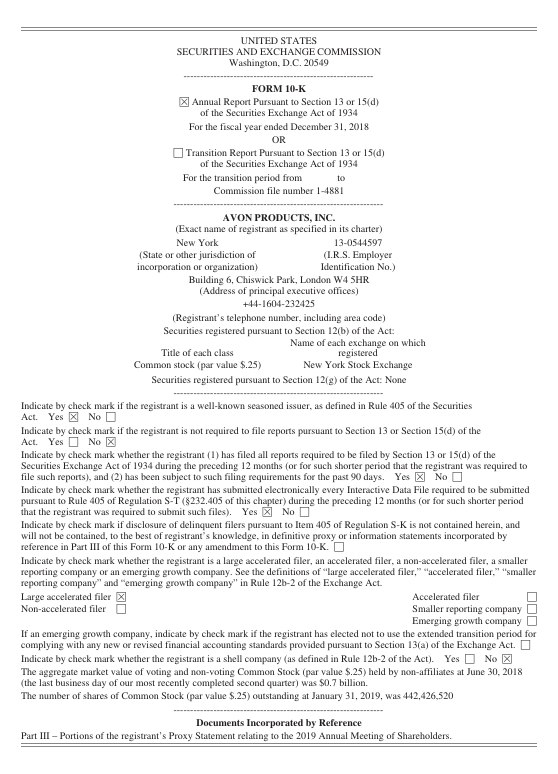

In [ ]:
visualize_pdf_image('report_1835.pdf', 7)

In [ ]:
# Converting submission to CSV

# submission.to_csv('/kaggle/working/submission.csv', index=False)
submission.to_csv('submission.csv', index=False)